In [2]:
#The purpose of this code is to organize data from an ESPN Fantasy Football league so that I can give detailed weekly updates
#to the league around scoring and results and identify anomalies and interesting facts. I do a weekly writeup of ~1000 words to keep
#people in the league engaged and make it a more communal experience, this supports that writing.

#https://stmorse.github.io/journal/espn-fantasy-v3.html
#https://www.reddit.com/r/fantasyfootball/comments/d6uf1p/espn_v3_api_endpoints/
#https://github.com/mkreiser/ESPN-Fantasy-Football-API
#https://matplotlib.org/stable/gallery/color/named_colors.html (Colors)

#Version 3: updated with new API endpoints from the ESPN fantasy API
#Version 4: updated with environment variables for the authentication keys

import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

#set a variable based on what NFL season we are interested in
year = 2024

#Every week I set the week to pull data for, because automating this based on which week of the season we are in wasn't worth the effort and sometimes I need to look at a historical week
weekval = 17

#Set some variables that we need to be able to pull data from the API
league_id = os.environ['ESPNFTSY_LGID']
url = "https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/" + str(year) + "/segments/0/leagues/"+ str(league_id)
cookies={"swid": '{' + os.environ['API_EF_SWID'] + '}',"espn_s2": os.environ['API_EF_S2']}  #Uses OAuth2 authentication
output_folder = os.environ['output_path']

In [3]:
#This module pulls matchup info for the different weeks in the season, including playoffs

#This block of team data will allow us to pull data to join on the 'teamID' value rather than the owner ID which is less consistent
r = requests.get(url, cookies=cookies, params={"view": "mMatchup"})

#get the result in a json format
d = r.json()

#Create a list with the data we need from the matchup endpoint
ls_m = []

#create a dataframe with these initial fields
df_matchup = pd.DataFrame(columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])

#Loop through each game int he schedule and pull the 5 required fields out of the API data set
for game in d['schedule']:
    
    #Week 15 (round 1 of fantasy playoffs) is what is causing the need to do this try/except, teams with a playoff bye are
    #shown as having a home team with no away team, so if we can't find elements of this 
    try:

        #append the new data to a list. Doing this as a list and then converting to a dataframe is more efficient than other append methods
        ls_m.append({'Week' : game['matchupPeriodId'],
                     'Team1' : game['home']['teamId'],
                     'Score1' : game['home']['totalPoints'],
                     'Team2' : game['away']['teamId'],
                     'Score2' : game['away']['totalPoints']})
    
    #if we are excluding a week due to an error, let the user know that we did. We should only see an exclusion for week 15
    except:
        print("Excluded row in week " + str(game['matchupPeriodId']))

#convert the list to a dataframe
df_matchup = pd.DataFrame.from_records(ls_m)

#Add a field indicating whether this is the playoffs or a regular season matchup
df_matchup['Type'] = ['Regular' if w<=14 else 'Playoff' for w in df_matchup['Week']]

#Add a field to indicate who won the matchup
df_matchup['Win'] = np.where(df_matchup['Score1'] > df_matchup['Score2'], df_matchup['Team1'],df_matchup['Team2'])

#we only need records for weeks that actually have scores
df_matchup = df_matchup[df_matchup['Score1']>0]


Excluded row in week 15
Excluded row in week 15


In [4]:
#Pull general team detail that will be used to pair with other scoring information later

#This block of team data will allow us to pull data to join on the 'teamID' value rather than the owner ID which is less consistent
r = requests.get(url, cookies=cookies, params={"view": "mTeam"})

#get the result in a json format
d = r.json()

#create some variables to hold our data
ls_t = []
ls_m = []

#loop through each team and grab the appropriate info
for i in d['teams']:
    ls_t.append({'id': i['id'],
                 'abbrev': i['abbrev'],
                 'owner_id': i['primaryOwner'],
                 'name': i['name']})

#loop through the member data
for i in d['members']:
    ls_m.append({'owner_id': i['id'],
                 'owner_firstname': i['firstName'],
                 'owner_lastname': i['lastName']})

#convert this data to a dataframe
df_member = pd.DataFrame.from_records(ls_m)
df_teams = pd.DataFrame.from_records(ls_t)

#Add a field for the owner's full name
df_member['owner_fullname'] = df_member['owner_firstname'] + ' ' + df_member['owner_lastname']

#merge the two data frames together
df_teams = df_teams.merge(df_member, how = 'left', left_on='owner_id', right_on='owner_id')


In [5]:
#Build an exportable matchup dataframe for adhoc analysis 

#Reduce the team dataframe to just the ID and name to make the joins cleaner
df_team_map = df_teams[['id','name']]                       

#Merge the team names for team1 and team2 into the dataframe
df_matchup_ex = df_matchup.merge(df_team_map,how = 'left', left_on = 'Team1', right_on = 'id')
df_matchup_ex = df_matchup_ex.merge(df_team_map,how = 'left', left_on = 'Team2', right_on = 'id')

#Rename the columns
df_matchup_ex = df_matchup_ex.rename(columns ={'name_x': 'Team 1', 'name_y': 'Team 2'})

#Keep only certain columns and rearrange them
df_matchup_ex = df_matchup_ex[['Week','Team 1','Score1','Team 2','Score2','Type']]

df_matchup_ex['Margin'] = abs(df_matchup_ex['Score1'] - df_matchup_ex['Score2'])

#drop this file so we can do some ad-hoc analysis on it
df_matchup_ex.to_excel(output_folder + "FF Matchup Data_" + str(year) + ".xlsx", freeze_panes=(1, 1), index=False)

In [6]:
#Create a data frame with average weekly score

#Pivot the dataframe so there is one record for each team so this isn't weekly matchup dependent
df_tmscore = pd.concat([df_matchup[['Week', 'Team1', 'Score1', 'Type', 'Win']].rename(columns={'Team1': 'Team', 'Score1': 'Score'}),
                       df_matchup[['Week', 'Team2', 'Score2', 'Type', 'Win']].rename(columns={'Team2': 'Team', 'Score2': 'Score'})])

#Add a column indicating if this week was a win or loss
df_tmscore['Team_Win'] = np.where(df_tmscore['Win'] == df_tmscore['Team'],True,False)

#Aggregate the average score by week
df_weekscore = df_tmscore.groupby('Week', as_index = True)['Score'].mean()

#Merge the weekly average back onto the main dataframe
df_tmscore = df_tmscore.merge(df_weekscore, how='left', left_on = 'Week', right_on = 'Week')

#We have 2 ambiguous columns titled "score" so let's make those more specific
df_tmscore = df_tmscore.rename(columns= {'Score_x': 'TeamScore','Score_y': 'WeeklyAvg'})

#Add a column to get the difference between the team score and the weekly average
df_tmscore = df_tmscore.assign(Score_over_Avg = df_tmscore['TeamScore'] - df_tmscore['WeeklyAvg'])

#merge so we can get the team name
df_tmscore = df_tmscore.merge(df_teams, how = 'left',left_on = "Team",right_on = "id")

#Rename this so the downstream code works and it looks better on a chart. Originally I created this 
#by combining location and nickname but later found a new endpoint that allows me to pull the current name directly
df_tmscore = df_tmscore.rename(columns={'name': 'TeamName'})

#we don't need these columns anymore
df_tmscore = df_tmscore.drop(columns=['abbrev','id'])

#sort by week
df_tmscore = df_tmscore.sort_values(by=['Week','Score_over_Avg'])

#create a data set for just the current week
df_tmscore_wk = df_tmscore[df_tmscore['Week']==weekval]

#rearrange and print columns
df_tmscore_wk = df_tmscore_wk.loc[:,['Week','TeamName','Team','TeamScore','Type','Win','Team_Win','WeeklyAvg','Score_over_Avg']]

#Display the result so we can review 
df_tmscore_wk


,Week,TeamName,Team,TeamScore,Type,Win,Team_Win,WeeklyAvg,Score_over_Avg
196,17,7 and 7,4,85.80,Playoff,1,False,126.370833,-40.570833
98,17,Boiler Up,12,93.30,Playoff,6,False,126.370833,-33.070833
100,17,Chicago Enforcers,8,98.60,Playoff,9,False,126.370833,-27.770833
99,17,Riddickulously Goodlooking,13,99.55,Playoff,11,False,126.370833,-26.820833
200,17,Diamond Dogs,11,111.60,Playoff,11,True,126.370833,-14.770833
201,17,SECONDARY DANS,9,113.75,Playoff,9,True,126.370833,-12.620833
96,17,misplaced pants,3,131.45,Playoff,5,False,126.370833,5.079167
198,17,Polk High,2,134.25,Playoff,7,False,126.370833,7.879167
197,17,Holdout_Havoc!,5,149.15,Playoff,5,True,126.370833,22.779167
199,17,Pink Fluffy Unicorns,6,160.80,Playoff,6,True,126.370833,34.429167


In [7]:
#Prep final data so we can get ready for the real analysis

#Get the columns we need 
df_final = df_tmscore[['Week', 'Team', 'TeamScore', 'Type', 'Win', 'Team_Win', 'WeeklyAvg', 'Score_over_Avg', 'TeamName']]


[Text(0.5, 1.0, 'Week 17 Score Results')]

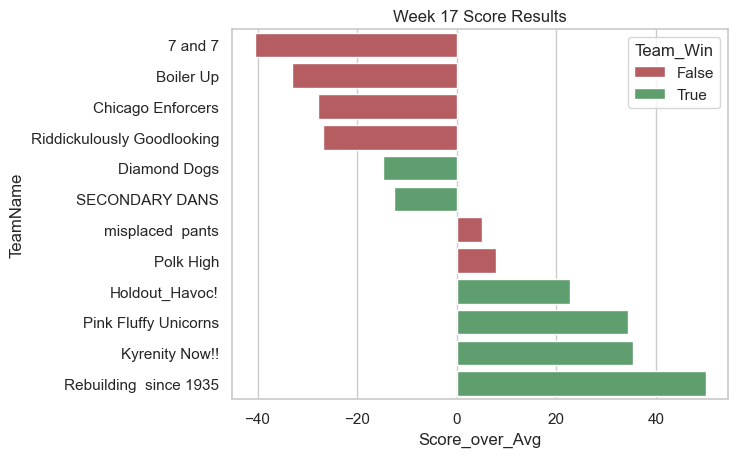

In [8]:
#Create the final weekly score over average chart

#we only need records for weeks that actually have scores
df_week = df_final[df_final['Week']==weekval]

#Sort by the difference column so the visual is more organized
df_week = df_week.sort_values(by=["Score_over_Avg"],ascending=True)

#set some properties of the charts
sns.set_theme(style="whitegrid")

#configure the final weekly scoring chart
sns.barplot(data=df_week, x='Score_over_Avg', y='TeamName', hue='Team_Win',
            palette={True:'g', False:'r'},
            dodge=False,
            orient = 'h').set(title = "Week " + str(weekval) + " Score Results")


[Text(0.5, 1.0, 'Week 17 Player Results')]

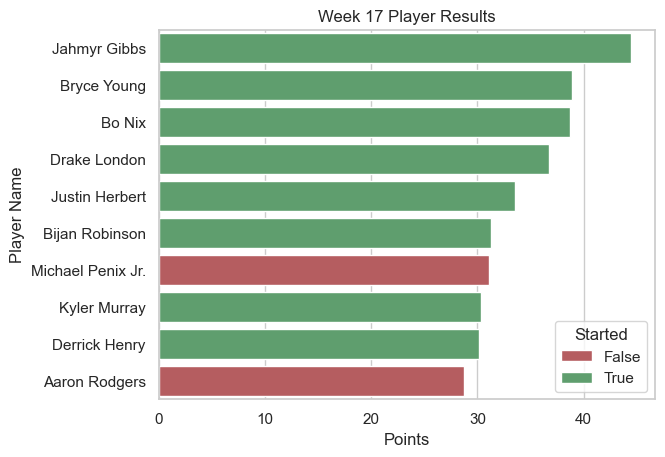

In [9]:
#Pull individual player performance data
#*The "started" true/false indicator doesn't entirely work, it is pulling the position that someone is CURRENTLY in, not where they were played in the most recent week
#but if this code is run shortly after the week ends it should catch whether the player was started that week
#the rest of this chart, which just shows the highest individual scorers week, is still valuable for my weekly write-ups

#Read in the mapping of position ID's to names, this was manually generated because there are only 6 values
df_position_map = pd.read_excel(output_folder + "FF_PositionMap.xlsx")

#Get data from the endpoint and format as json
r = requests.get(url, cookies=cookies, params={"view": "mMatchup"})

#convert the data to json format
d = r.json()

#create a list we can use to append new data to
ls_p = []

#Loop through each team
for tm in d['teams']:
    
    #Loop through each player assigned to that team
    for p in tm['roster']['entries']:
        
        #append new data to the list
        ls_p.append({'Week' : weekval,
                     'id' : p['playerPoolEntry']['onTeamId'], 
                     'Player Name' : p['playerPoolEntry']['player']['fullName'], 
                     'Position' : p['playerPoolEntry']['player']['defaultPositionId'], 
                     'Points': p['playerPoolEntry']['appliedStatTotal'],
                     'Slot': p['lineupSlotId']})                 

#convert the accumulated players data to a dataframe
df_players = pd.DataFrame.from_records(ls_p)
        
#Merge the team names for team1 and team2 into the dataframe
df_players = df_players.merge(df_team_map,how = 'left', left_on = 'id', right_on = 'id')

#Merge the team names for team1 and team2 into the dataframe
df_players = df_players.merge(df_position_map,how = 'left', left_on = 'Position', right_on = 'ID')

#Rename the columns
df_players = df_players.rename(columns ={'name': 'TeamName', 'Abbrev': 'Player Position'})

#Create a column to identify if the player was started or not, Started defined as a lineup slot is not equal to 20, slot 20 is the bench
df_players['Started'] = np.where(df_players['Slot'] != 20,True,False)

#Rearrange and drop things we no longer need
df_players = df_players[['Week','TeamName','Player Name','Player Position','Points','Slot','Started']]

#sort by points scored
df_players = df_players.sort_values(by=['Week','Points'], ascending=False)

#optional - export for analysis
df_players.to_excel(output_folder + "FF Player_" + str(year) + "_Week" + str(weekval) + ".xlsx", freeze_panes=(1, 1), index=False)

#create a barplot to show the top scorers and whether or not they were in the starting lineup
sns.barplot(data=df_players.head(10), x='Points', y='Player Name', hue='Started',
            palette={True:'g', False:'r'},
            dodge=False,
            orient = 'h').set(title = "Week " + str(weekval) + " Player Results")

In [10]:
#Get the highest score from each week, this is important to give information on who gets the weekly payout for having the highest score
#https://stackoverflow.com/questions/53842287/select-rows-with-highest-value-from-groupby

df_highscore = df_final.loc[df_final.groupby("Week")["TeamScore"].idxmax()]

#Pull only the values we need
df_highscore = df_highscore[["Week","TeamName","TeamScore"]]

#Rename the last column to make it more specific
df_highscore = df_highscore.rename(columns= {'TeamScore': 'Weekly High Score'})

df_highscore

,Week,TeamName,Weekly High Score
1,1,misplaced pants,141.20
112,2,7 and 7,156.75
15,3,misplaced pants,139.85
18,4,Riddickulously Goodlooking,139.40
24,5,Boiler Up,150.05
35,6,misplaced pants,187.70
41,7,Holdout_Havoc!,139.65
143,8,7 and 7,152.80
49,9,7 and 7,156.80
56,10,Polk High,163.00


In [ ]:
#summarize the number of times a team had the high score each week

#Add a counter value for winning the week
df_highscore['Winner'] = 1

#group by team and sum this value to get the total times each team won the week
df_hs_tm = df_highscore.groupby("TeamName")["Winner"].sum().to_frame(name = 'Winner').reset_index()

#sort the data by winning amount
df_hs_tm = df_hs_tm.sort_values(by=["Winner","TeamName"], ascending = False)

df_hs_tm

,TeamName,Winner
8,misplaced pants,3
6,Rebuilding since 1935,3
0,7 and 7,3
7,Riddickulously Goodlooking,2
4,Pink Fluffy Unicorns,2
5,Polk High,1
3,Holdout_Havoc!,1
2,Chicago Enforcers,1
1,Boiler Up,1


[Text(0.5, 1.0, 'Regular Season Standard Deviations')]

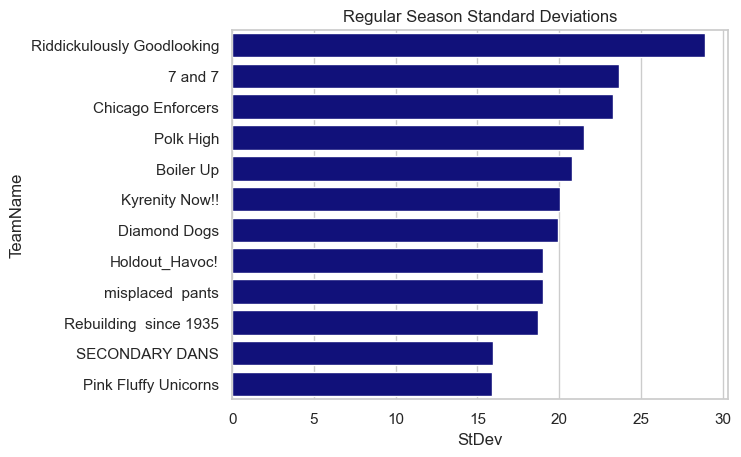

In [20]:
#Create charts to show various regular season team stats - standard deviations of weekly scores

#Get just the regular season scores, defined by week <= 14
df_reg = df_final[df_final['Week']<= 14]

#Get the teams and the aggregated standard deviations
df_std = df_reg.groupby(['TeamName'])['TeamScore'].std().to_frame(name = 'StDev').reset_index()

#sort the standard deviation dataframe
df_std = df_std.sort_values(by=["StDev"],ascending=False)

#Plot the data, using a sorted version of df_std
sns.barplot(data=df_std, x='StDev', y='TeamName',
            dodge=False,
            orient = 'h',
            color = 'darkblue').set(title = "Regular Season Standard Deviations")


[Text(0.5, 1.0, 'Regular Season Weekly Average Score')]

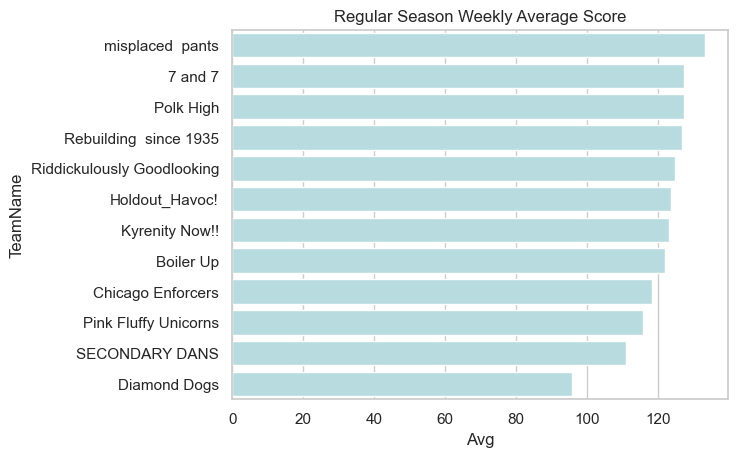

In [21]:
##Create charts to show various regular season team stats - average weekly scores

#Get the teams and the aggregated standard deviations
df_avg = df_reg.groupby(['TeamName'])['TeamScore'].mean().to_frame(name = 'Avg').reset_index()

#Sort the values and print it so we can see the individual values
df_avg = df_avg.sort_values(by=["Avg"],ascending=False)

#Plot the data, using a sorted version of df_std
sns.barplot(data=df_avg, x='Avg', y='TeamName',
            dodge=False,
            orient = 'h',
            color = 'powderblue').set(title = "Regular Season Weekly Average Score")

[Text(0.5, 1.0, 'Regular Season Median Score')]

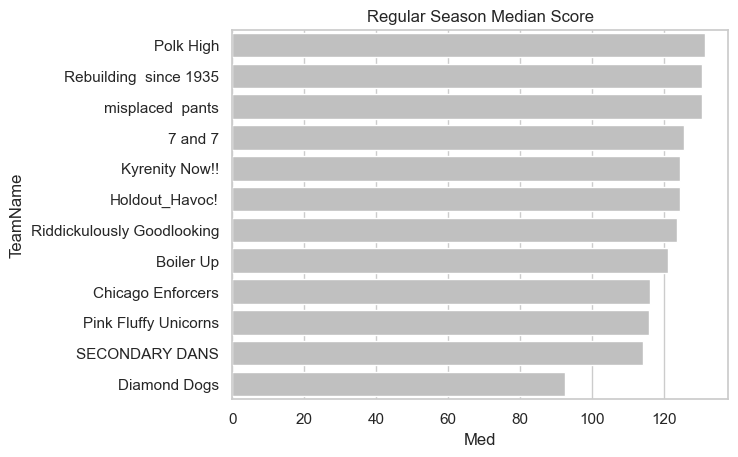

In [22]:
#Create charts to show various regular season team stats - median scores data set

#Get the teams and the aggregated standard deviations
df_med = df_reg.groupby(['TeamName'])['TeamScore'].median().to_frame(name = 'Med').reset_index()

#Sort the values and print it so we can see the individual values
df_med = df_med.sort_values(by=["Med"],ascending=False)

#Plot the data, using a sorted version of df_std
sns.barplot(data=df_med, x='Med', y='TeamName',
            dodge=False,
            orient = 'h',
            color = 'silver').set(title = "Regular Season Median Score")

<Axes: xlabel='TeamName', ylabel='TeamScore'>

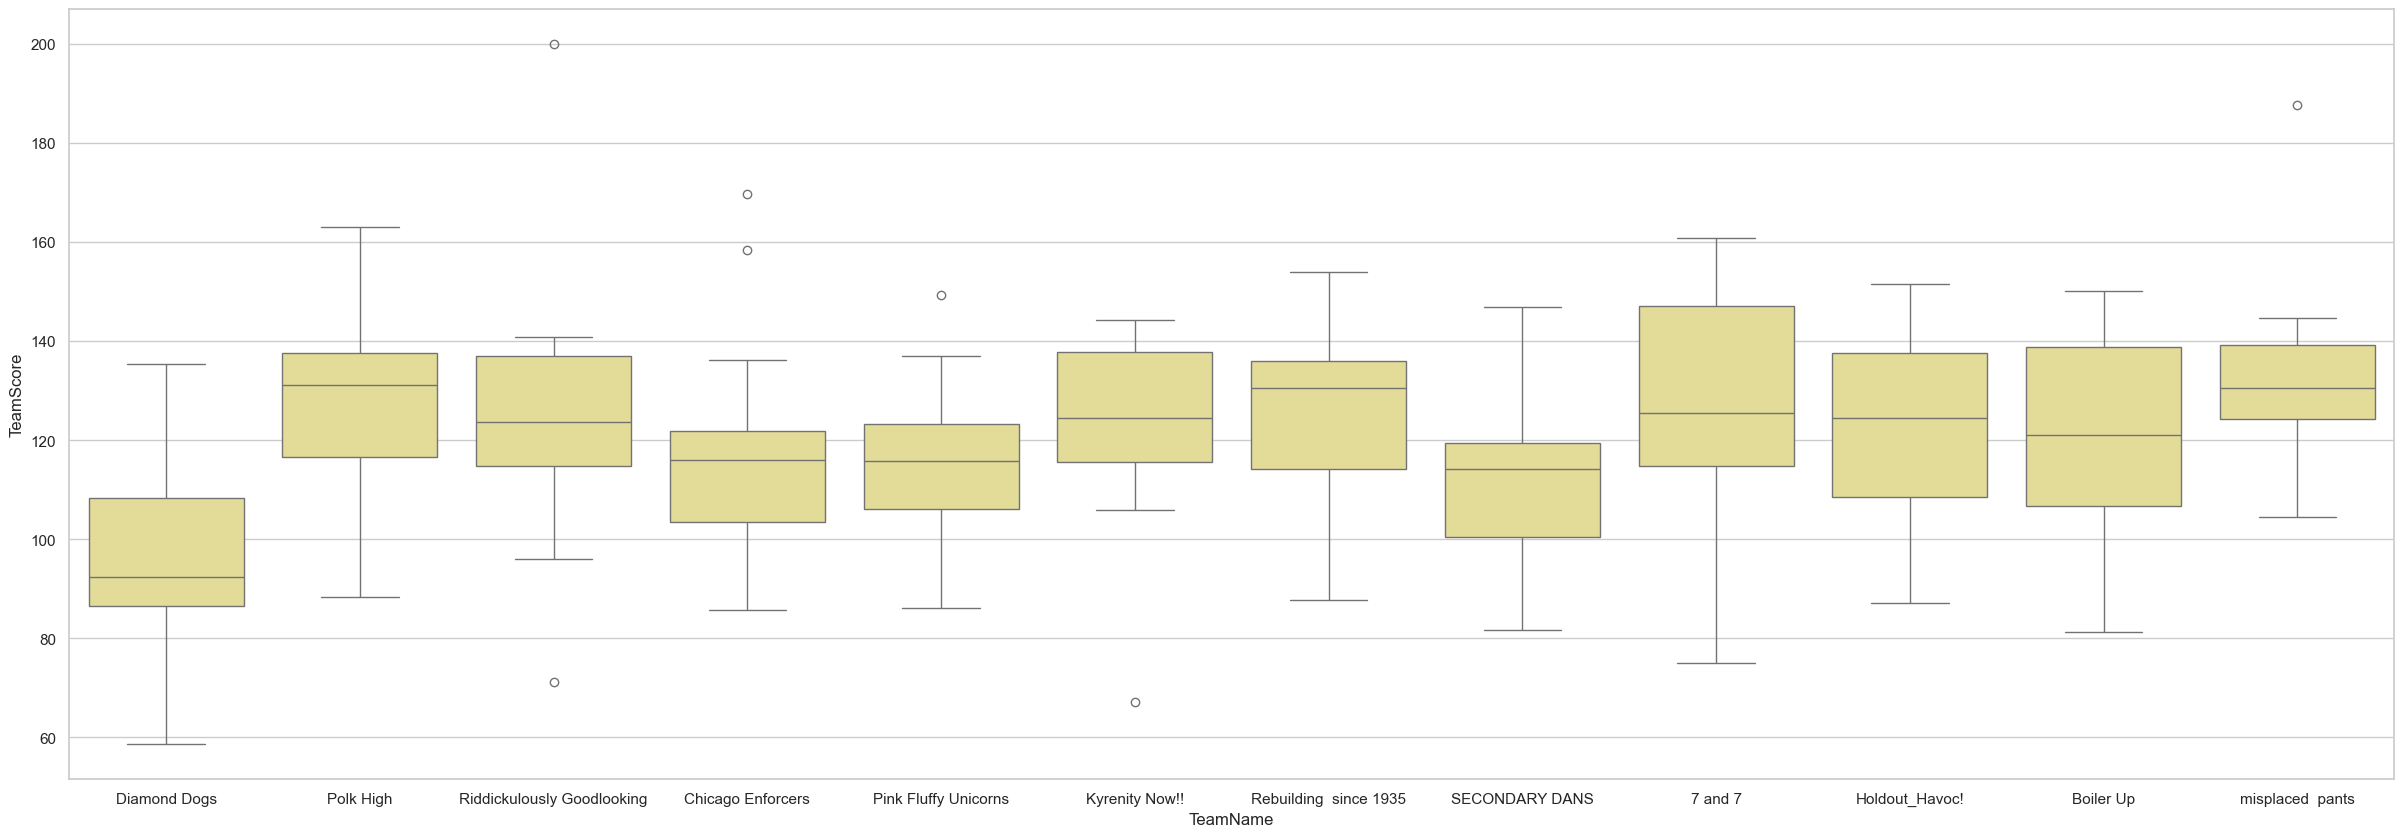

In [23]:
#Create charts to show various team stats - box and whisker plot for regular season team scores

#set some parameters to make it fit the page better
fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)

#create the chart and display it
sns.boxplot(x="TeamName", y="TeamScore", data=df_reg, ax = ax, color='khaki')

In [25]:
#Get the league weekly average score to see the trends

#Get the average score of the 
df_Averagescore = df_final.loc[df_final.groupby("Week")["WeeklyAvg"].idxmax()]

#Pull only the values we need
df_Averagescore = df_Averagescore[["Week","WeeklyAvg"]]

#print the dataframe
df_Averagescore

,Week,WeeklyAvg
106,1,113.091667
10,2,112.704167
17,3,117.179167
22,4,115.500000
25,5,128.287500
33,6,122.516667
140,7,111.079167
145,8,130.695833
51,9,124.050000
54,10,110.600000
